## Time series clustering with tslearn

In this notebook we will use the `tslearn` library to cluster time series (stocks) from the NDX100.

In [1]:
# If you'd like to install packages that are not installed by default, uncomment the last two lines of this cell and replace  with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere
# import sys
# !{sys.executable} -m pip install matplotlib numpy pandas tslearn yfinance

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [12]:
# import libraries
import matplotlib
import requests
#
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
#
from datetime import datetime
from matplotlib import pyplot as plt
from tslearn.clustering import TimeSeriesKMeans

# https://www.pythonforfinance.net/2018/02/08/stock-clusters-using-k-means-algorithm-in-python/
# https://andrewm4894.com/2020/09/03/time-series-clustering-with-tslearn/
# https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html
# https://towardsdatascience.com/explain-ml-in-a-simple-way-k-means-clustering-e925d019743b

In [13]:
# utils

#Function to generate the dataset
def dataset(ticker, days=4000):
    # Define time to download data
    today = datetime.today()
    initial = today - dt.timedelta(days=days)
    today = today.strftime('%Y-%m-%d')
    initial = initial.strftime('%Y-%m-%d')
    #Download data with YFINANCE
    df = yf.download(ticker, start=initial, end=today, progress=False)
    return df

# 1. Import NDX100 tickers

In [14]:
headers={"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"}
res=requests.get("https://api.nasdaq.com/api/quote/list-type/nasdaq100",headers=headers)
main_data=res.json()['data']['data']['rows']

symbols = []
for i in range(len(main_data)):
    print(main_data[i]['companyName'])
    symbols.append(main_data[i]['symbol'])
symbols.sort()

Apple Inc.
Amgen Inc.
Comcast Corporation
Intel Corporation
KLA Corporation
PACCAR Inc.
Cintas Corporation
Paychex, Inc.
Lam Research Corporation
Autodesk, Inc.
Ross Stores, Inc.
Monster Beverage Corporation
Microsoft Corporation
Adobe Inc.
Fiserv, Inc.
Fastenal Company
Electronic Arts Inc.
Cisco Systems, Inc.
Regeneron Pharmaceuticals, Inc.
IDEXX Laboratories, Inc.
Vertex Pharmaceuticals Incorporated
Biogen Inc.
Old Dominion Freight Line, Inc.
QUALCOMM Incorporated
Gilead Sciences, Inc.
Synopsys, Inc.
Starbucks Corporation
Sirius XM Holdings Inc.
Intuit Inc.
Microchip Technology Incorporated
O'Reilly Automotive, Inc.
Dollar Tree, Inc.
ASML Holding N.V.
ANSYS, Inc.
Cognizant Technology Solutions Corporation
CoStar Group, Inc.
eBay Inc.
NVIDIA Corporation
Booking Holdings Inc.
Intuitive Surgical, Inc.
Marvell Technology, Inc.
Illumina, Inc.
Analog Devices, Inc.
American Electric Power Company, Inc.
Advanced Micro Devices, Inc.
Cadence Design Systems, Inc.
CSX Corporation
Honeywell Inter

In [15]:
symbols

['AAPL',
 'ABNB',
 'ADBE',
 'ADI',
 'ADP',
 'ADSK',
 'AEP',
 'ALGN',
 'AMAT',
 'AMD',
 'AMGN',
 'AMZN',
 'ANSS',
 'ASML',
 'ATVI',
 'AVGO',
 'AZN',
 'BIIB',
 'BKNG',
 'BKR',
 'CDNS',
 'CEG',
 'CHTR',
 'CMCSA',
 'COST',
 'CPRT',
 'CRWD',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTSH',
 'DDOG',
 'DLTR',
 'DXCM',
 'EA',
 'EBAY',
 'ENPH',
 'EXC',
 'FANG',
 'FAST',
 'FISV',
 'FTNT',
 'GFS',
 'GILD',
 'GOOG',
 'GOOGL',
 'HON',
 'IDXX',
 'ILMN',
 'INTC',
 'INTU',
 'ISRG',
 'JD',
 'KDP',
 'KHC',
 'KLAC',
 'LCID',
 'LRCX',
 'LULU',
 'MAR',
 'MCHP',
 'MDLZ',
 'MELI',
 'META',
 'MNST',
 'MRNA',
 'MRVL',
 'MSFT',
 'MU',
 'NFLX',
 'NVDA',
 'NXPI',
 'ODFL',
 'ORLY',
 'PANW',
 'PAYX',
 'PCAR',
 'PDD',
 'PEP',
 'PYPL',
 'QCOM',
 'REGN',
 'RIVN',
 'ROST',
 'SBUX',
 'SGEN',
 'SIRI',
 'SNPS',
 'TEAM',
 'TMUS',
 'TSLA',
 'TXN',
 'VRSK',
 'VRTX',
 'WBA',
 'WBD',
 'WDAY',
 'XEL',
 'ZM',
 'ZS']

In [16]:
# retrieve time series for all stocks
df = pd.DataFrame()
for symbol in symbols:
    if df.empty:
        df=dataset(symbol)['Open']
        df.name = symbol
    else:
        df2 = dataset(symbol)['Open']
        df2.name = symbol
        df = pd.concat([df,df2], axis=1)

for s in df.columns:
    if df[s].isna().any():
        df.pop(s)
df = df/df.iloc[0]

In [17]:
df.head()

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,AMAT,AMD,AMGN,...,SIRI,SNPS,TMUS,TSLA,TXN,VRSK,VRTX,WBA,WBD,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-12,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2012-01-13,0.993890,0.989127,1.001351,0.998171,0.989793,0.993467,1.010386,0.994920,0.987993,1.012824,...,1.029268,0.998557,1.000000,0.997191,1.010393,0.984135,0.988204,0.971027,1.003948,0.962472
2012-01-17,1.004547,0.991165,0.998108,1.005852,1.005258,1.006049,1.007478,0.999153,0.989708,1.024442,...,1.053659,1.008661,1.005917,0.934691,1.017863,0.995538,0.984450,0.963711,1.021830,0.989330
2012-01-18,1.011083,0.994563,1.034865,1.020117,0.993814,1.004113,1.034898,1.006774,0.982847,1.022028,...,1.039024,1.009022,0.990533,0.937149,1.038324,0.974715,0.981233,0.971320,1.013237,0.983812
2012-01-19,1.018637,1.016310,1.058649,1.036211,1.064955,1.005323,1.027005,1.032176,1.032590,1.043150,...,1.053659,1.030675,1.028402,0.954705,1.086067,0.989341,1.005362,0.974832,1.021598,0.986019


# 2. Plot the Elbow Curve

Our first decision is to choose how many clusters do we actually want to separate the data into. Rather than make some arbitrary decision we can use an “Elbow Curve” to highlight the relationship between how many clusters we choose, and the Sum of Squared Errors (SSE) resulting from using that number of clusters.

We then plot this relationship to help us identify the optimal number of clusters to use – we would prefer a lower number of clusters, but also would prefer the SSE to be lower – so this trade off needs to be taken into account.

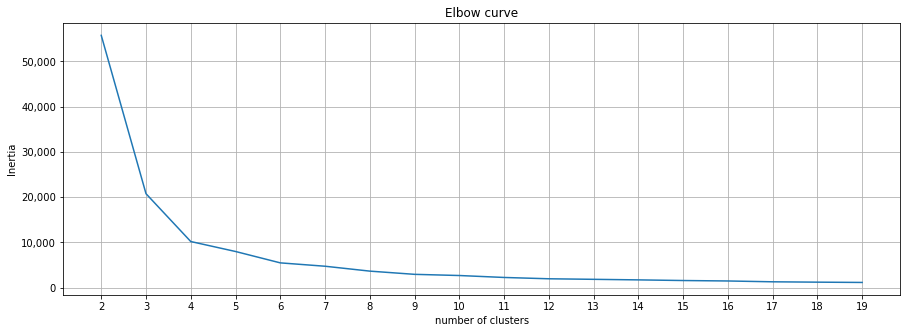

In [18]:
distorsions = []
for k in range(2, 20):
    tskm = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=10000, random_state=0)
    tskm.fit(df.transpose().values)
    distorsions.append(tskm.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.xticks(np.arange(2,20))
plt.xlabel('number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve')
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
plt.savefig('Elbow_curve.png')
plt.show()
plt.close()

So we can see that once the number of clusters reaches 4 (on the bottom axis), the reduction in the objective function (SSE, Cluster Inertia) begins to slow down for each increase in cluster number. 

This would lead us to believe that the optimal number of clusters for this exercise lies around the 4 mark.

# 3. Clustering model

In [19]:
model = TimeSeriesKMeans(n_clusters=4, metric="euclidean", max_iter=10000, random_state=0).fit(df.transpose().values)
labels = model.labels_

In [20]:
labels

array([0, 0, 3, 3, 3, 3, 0, 0, 0, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 0, 0, 3,
       3, 0, 3, 0, 3, 0, 3, 3, 2, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 0, 0, 2, 2, 0, 0, 3, 3, 3, 3,
       3, 0, 3, 3, 0, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3], dtype=int64)

# 4. Plot the clusters

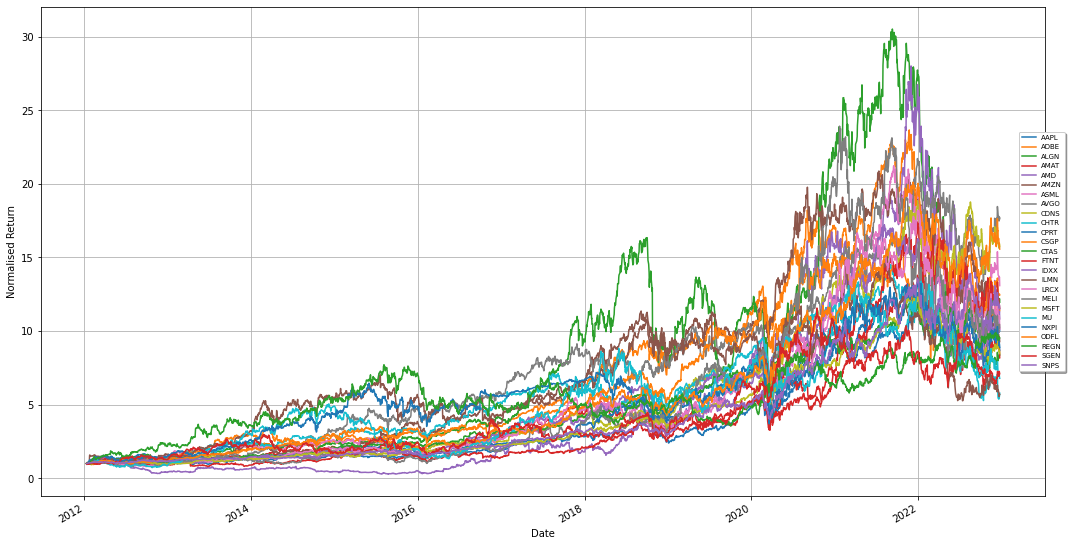

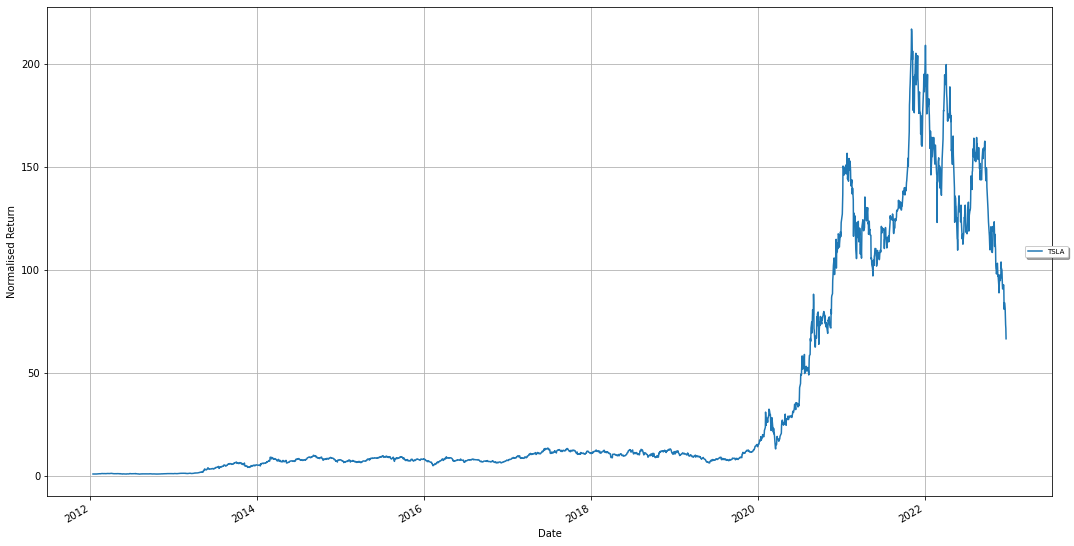

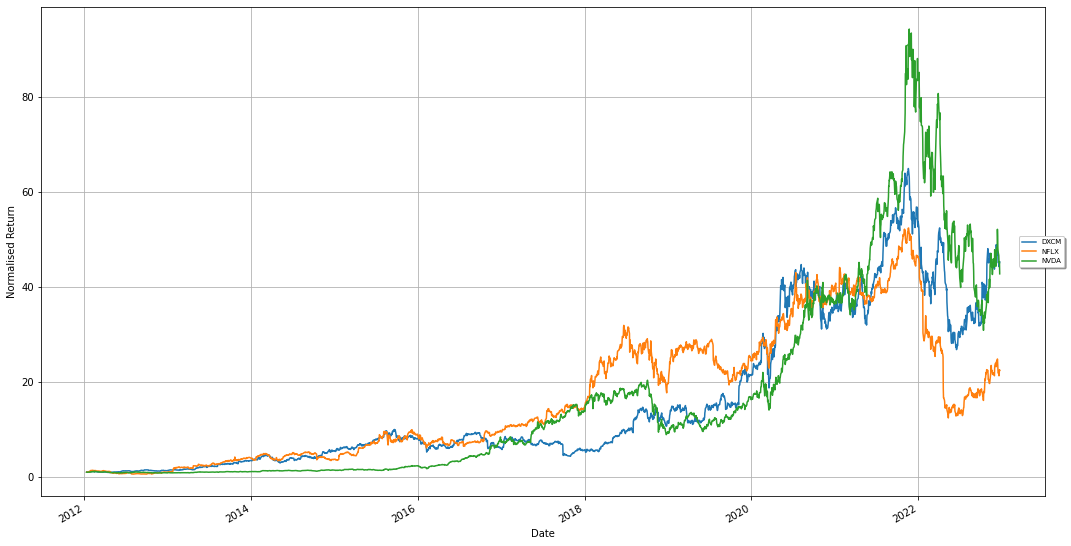

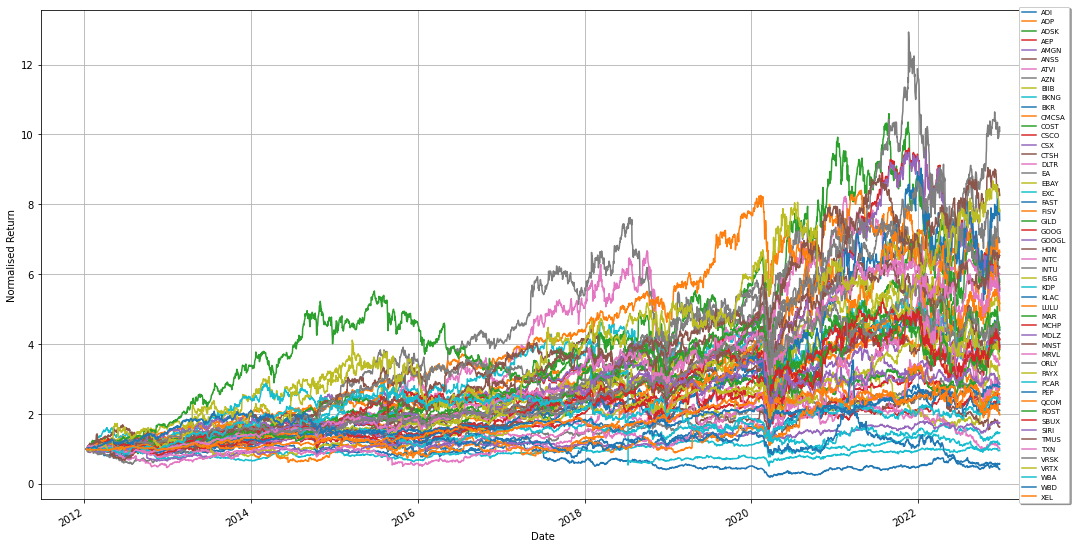

In [21]:
df_cluster = pd.DataFrame(list(zip(df.columns, model.labels_)), columns=['symbol', 'cluster'])
for k in set(labels):
    cluster = df_cluster.loc[df_cluster['cluster']==k]
    stocks = cluster['symbol']
    stocks = df[stocks]
    stocks.plot(y=stocks.columns,figsize=(18, 10))
    # plt.tight_layout()
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(0.97, 0.5), fancybox=True, shadow=True, fontsize=7)
    plt.ylabel('Normalised Return')
    plt.xlabel('Date')
    plt.savefig(f'cluster_{k}.png')
    plt.show()
    plt.close()

As it is typical with clustering you are always going to get some pretty bad random looking ones.

All in all, I found the tslearn library very useful as it saved me quite a bit of time to get a quick working prototype up and running.